## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from typing import Any, List, Dict, Tuple
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from tqdm import tqdm
import time
import random
# from joblib import Parallel, delayed

In [2]:
df = pd.read_csv('/content/mushroom_cleaned.csv')
df.head()
X = df.loc[ : , df.columns != 'class']
y = df['class']

random.seed(97)

In [3]:
X.head(3)

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season
0,1372,2,2,10,3.807467,1545,11,1.804273
1,1461,2,2,10,3.807467,1557,11,1.804273
2,1371,2,2,10,3.612496,1566,11,1.804273


In [4]:
y.head(3)

,class
0,1
1,1
2,1


## EDA

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54035 entries, 0 to 54034
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cap-diameter     54035 non-null  int64  
 1   cap-shape        54035 non-null  int64  
 2   gill-attachment  54035 non-null  int64  
 3   gill-color       54035 non-null  int64  
 4   stem-height      54035 non-null  float64
 5   stem-width       54035 non-null  int64  
 6   stem-color       54035 non-null  int64  
 7   season           54035 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 3.3 MB


In [6]:
X.describe()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season
count,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000
mean,567.257204,4.000315,2.142056,7.329509,0.759110,1051.081299,8.418062,0.952163
std,359.883763,2.160505,2.228821,3.200266,0.650969,782.056076,3.262078,0.305594
min,0.000000,0.000000,0.000000,0.000000,0.000426,0.000000,0.000000,0.027372
25%,289.000000,2.000000,0.000000,5.000000,0.270997,421.000000,6.000000,0.888450
50%,525.000000,5.000000,1.000000,8.000000,0.593295,923.000000,11.000000,0.943195
75%,781.000000,6.000000,4.000000,10.000000,1.054858,1523.000000,11.000000,0.943195
max,1891.000000,6.000000,6.000000,11.000000,3.835320,3569.000000,12.000000,1.804273


In [7]:
X.isna().sum()

,0
cap-diameter,0
cap-shape,0
gill-attachment,0
gill-color,0
stem-height,0
stem-width,0
stem-color,0
season,0


In [8]:
len(y[y == 1]), len(y[y == 0])

(29675, 24360)

In [9]:
for feature in X:
  print(f'Feature: {feature}')
  if len(X[feature].unique()) > 30:
    print('More than 30 unique values\n')
  else:
    print(f"{X[feature].unique()}\n")

Feature: cap-diameter
More than 30 unique values

Feature: cap-shape
[2 6 4 0 1 5 3]

Feature: gill-attachment
[2 0 1 5 6 4 3]

Feature: gill-color
[10  5  7  9  0  3 11  8  1  6  4  2]

Feature: stem-height
More than 30 unique values

Feature: stem-width
More than 30 unique values

Feature: stem-color
[11 12  6 10  0  5  9  8  1  4  3  7  2]

Feature: season
[1.80427271 0.94319455 0.88845029 0.02737213]



## Visual DA

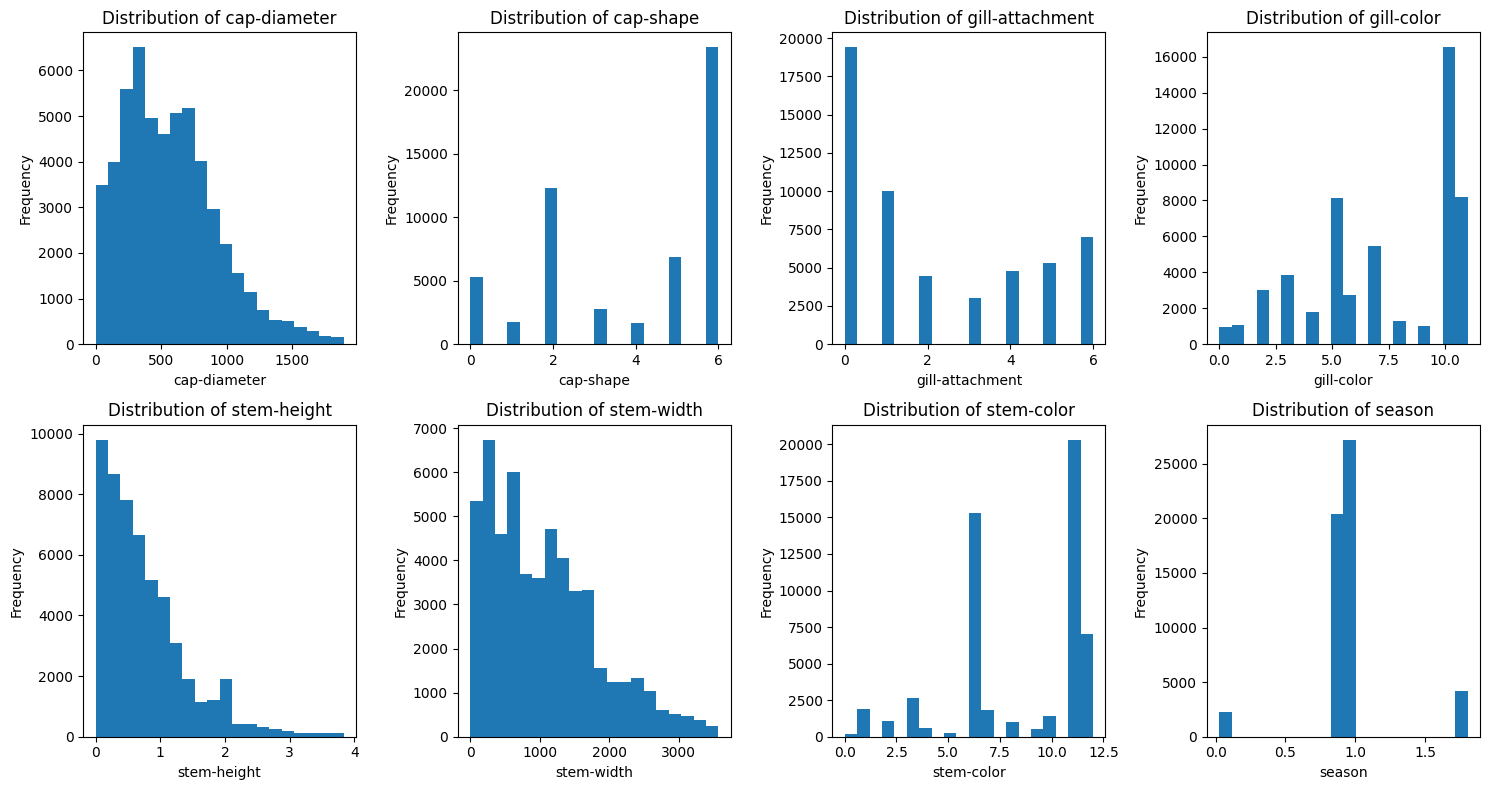

In [10]:
num_columns = len(X.columns)
cols = 4  # Number of columns in the grid (adjust as needed)
rows = math.ceil(num_columns / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))  # Adjust figure size as needed
axes = axes.flatten()  # Flatten to easily iterate over axes

for i, column in enumerate(X.columns):
    ax = axes[i]
    X[column].plot(kind='hist', bins=20, ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

<Axes: >

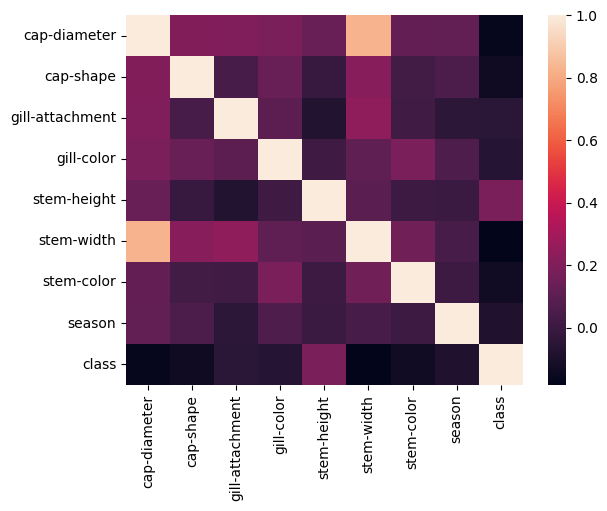

In [11]:
sns.heatmap(df.corr())

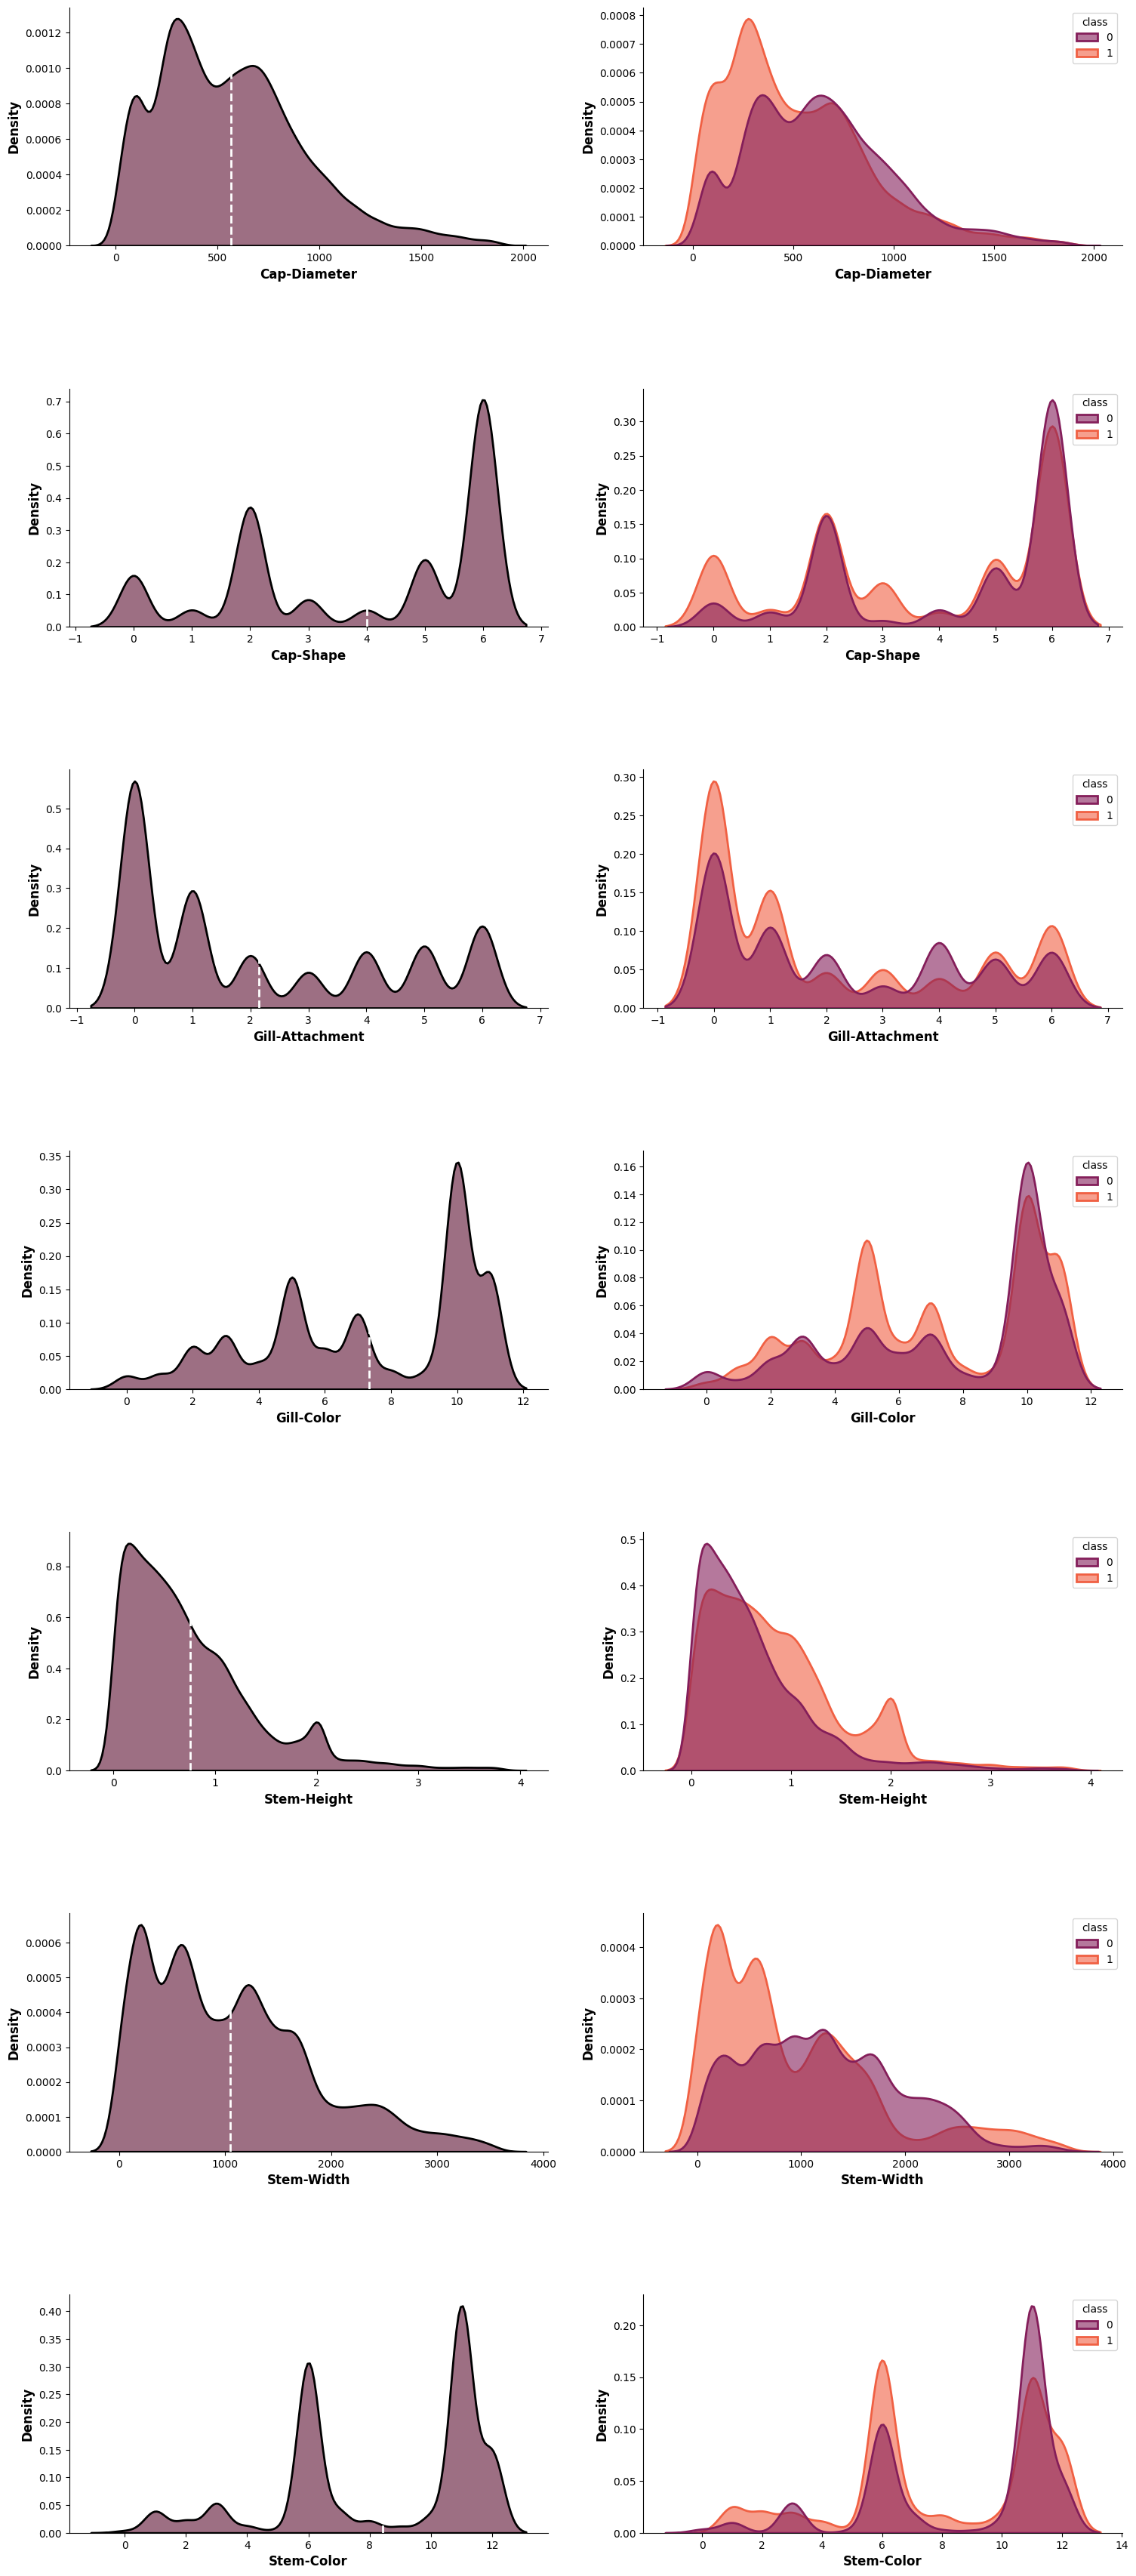

In [12]:
plotIndex = 1
plt.figure(figsize=(18,50))
for i in range(1, len(X.columns)):
    plt.subplot(len(X.columns), 2, plotIndex)
    sns.kdeplot(data=X, x=X.columns[i-1],
                fill=True, linewidth=2, color='#5c1031', alpha=0.6, edgecolor='k')
    plt.axvline(X[X.columns[i-1]].mean(), color='white', linestyle='--', linewidth=2)
    plt.xlabel(xlabel=X.columns[i-1].title(), fontsize=12, weight='bold')
    plt.ylabel(ylabel='Density', fontsize=12, weight='bold')
    sns.despine()

    plt.subplot(len(X.columns), 2, plotIndex+1)
    sns.kdeplot(data=X, x=X.columns[i-1],
                fill=True, hue=y, linewidth=2, palette='rocket', alpha=0.6)
    plt.xlabel(xlabel=X.columns[i-1].title(), fontsize=12, weight='bold')
    plt.ylabel(ylabel='Density', fontsize=12, weight='bold')
    sns.despine()


    plotIndex += 2
plt.subplots_adjust(hspace=0.6)
plt.show()

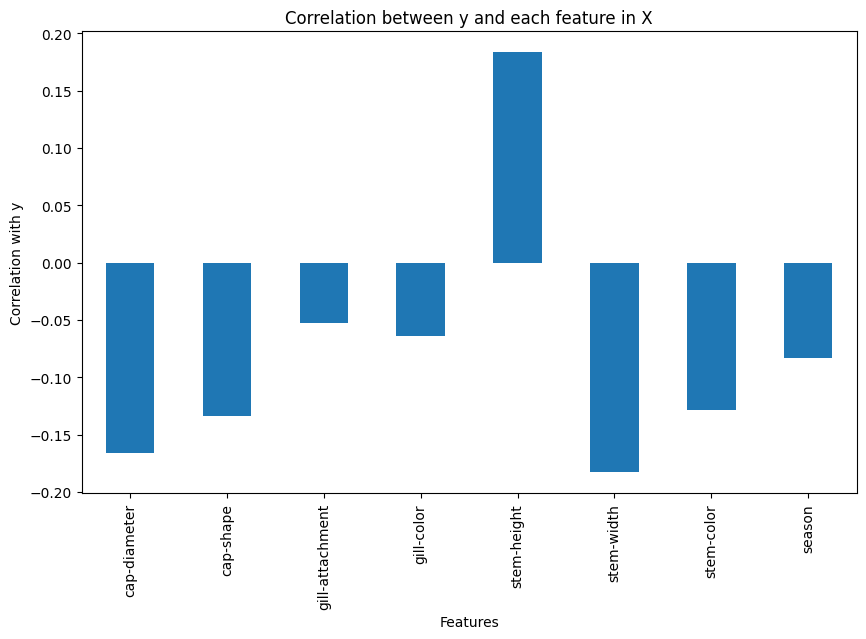

In [13]:
correlations = X.corrwith(y)
correlations.plot(kind='bar', figsize=(10, 6))
plt.title('Correlation between y and each feature in X')
plt.xlabel('Features')
plt.ylabel('Correlation with y')
plt.show()

## Binarization
For cap-shape, gill-attachment, gill-color, stem-color and season**(1-4 and 8)** I will use dummies (In other words, I will use **nominal scaling**).

For other features **(5-7)** I will divide interval into the bins and consider values $\ge and \le$ of thresholds. Here I apply **inter-ordinal scaling**.

In [14]:
X_binarized = X.copy()

In [15]:
print(f'{X_binarized["cap-shape"].unique()}')
print(f'{X_binarized["gill-attachment"].unique()}')
print(f'{X_binarized["gill-color"].unique()}')
print(f'{X_binarized["stem-color"].unique()}')
print(f'{X_binarized["season"].unique()}')

[2 6 4 0 1 5 3]
[2 0 1 5 6 4 3]
[10  5  7  9  0  3 11  8  1  6  4  2]
[11 12  6 10  0  5  9  8  1  4  3  7  2]
[1.80427271 0.94319455 0.88845029 0.02737213]


### 1. cap-shape

In [16]:
dummies = pd.get_dummies(X_binarized['cap-shape'], prefix='cap-shape', dtype='int')
X_binarized = pd.concat([X_binarized, dummies], axis=1)
X_binarized  = X_binarized.drop('cap-shape', axis=1)

### 2. gill-attachment

In [17]:
dummies = pd.get_dummies(X_binarized['gill-attachment'], prefix='gill-attachment', dtype='int')
X_binarized  = pd.concat([X_binarized, dummies], axis=1)
X_binarized  = X_binarized.drop('gill-attachment', axis=1)

### 3. gill-color

In [18]:
dummies = pd.get_dummies(X_binarized['gill-color'], prefix='gill-color', dtype='int')
X_binarized = pd.concat([X_binarized, dummies], axis=1)
X_binarized = X_binarized.drop('gill-color', axis=1)

### 4. stem-color

In [19]:
dummies = pd.get_dummies(X_binarized['stem-color'], prefix='stem-color', dtype='int')
X_binarized = pd.concat([X_binarized, dummies], axis=1)
X_binarized = X_binarized.drop('stem-color', axis=1)

### 5. cap-diameter

In [20]:
# Define the interval
start = X_binarized['cap-diameter'].min()
end = X_binarized['cap-diameter'].max()

# Calculate step size
step_size = (end - start) / 5

# Generate the thresholds
thresholds = [start + i * step_size for i in range(6)]

In [21]:
for threshold in thresholds:
    X_binarized[f'capd_le_{threshold}'] = X_binarized['cap-diameter'] <= threshold
    X_binarized[f'capd_ge_{threshold}'] = X_binarized['cap-diameter'] >= threshold

In [22]:
X_binarized = X_binarized.drop('cap-diameter', axis=1)

### 6. stem-height

In [23]:
start = X_binarized['stem-height'].min()
end = X_binarized['stem-height'].max()

step_size = (end - start) / 5

thresholds = [start + i * step_size for i in range(6)]

In [24]:
for threshold in thresholds:
    X_binarized[f'stemh_le_{threshold}'] = X_binarized['stem-height'] <= threshold
    X_binarized[f'stemh_ge_{threshold}'] = X_binarized['stem-height'] >= threshold

In [25]:
X_binarized = X_binarized.drop('stem-height', axis=1)

### 7. stem-width

In [26]:
start = X_binarized['stem-width'].min()
end = X_binarized['stem-width'].max()

step_size = (end - start) / 5

thresholds = [start + i * step_size for i in range(6)]

In [27]:
for threshold in thresholds:
    X_binarized[f'stemw_le_{threshold}'] = X_binarized['stem-width'] <= threshold
    X_binarized[f'stemw_ge_{threshold}'] = X_binarized['stem-width'] >= threshold

In [28]:
X_binarized = X_binarized.drop('stem-width', axis=1)

### 8. season

In [29]:
dummies = pd.get_dummies(X_binarized['season'], prefix='season', dtype='int')
X_binarized = pd.concat([X_binarized, dummies], axis=1)
X_binarized  = X_binarized.drop('season', axis=1)

In [30]:
X_binarized = X_binarized.astype('int')
X_binarized.head(4)

,cap-shape_0,cap-shape_1,cap-shape_2,cap-shape_3,cap-shape_4,cap-shape_5,cap-shape_6,gill-attachment_0,gill-attachment_1,gill-attachment_2,...,stemw_le_2141.3999999999996,stemw_ge_2141.3999999999996,stemw_le_2855.2,stemw_ge_2855.2,stemw_le_3569.0,stemw_ge_3569.0,season_0.0273721330556057,season_0.8884502877862838,season_0.9431945538974952,season_1.804272708628173
0,0,0,1,0,0,0,0,0,0,1,...,1,0,1,0,1,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,1,...,1,0,1,0,1,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,1,...,1,0,1,0,1,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,1,...,1,0,1,0,1,0,0,0,0,1


In [31]:
X_binarized.columns

Index(['cap-shape_0', 'cap-shape_1', 'cap-shape_2', 'cap-shape_3',
       'cap-shape_4', 'cap-shape_5', 'cap-shape_6', 'gill-attachment_0',
       'gill-attachment_1', 'gill-attachment_2', 'gill-attachment_3',
       'gill-attachment_4', 'gill-attachment_5', 'gill-attachment_6',
       'gill-color_0', 'gill-color_1', 'gill-color_2', 'gill-color_3',
       'gill-color_4', 'gill-color_5', 'gill-color_6', 'gill-color_7',
       'gill-color_8', 'gill-color_9', 'gill-color_10', 'gill-color_11',
       'stem-color_0', 'stem-color_1', 'stem-color_2', 'stem-color_3',
       'stem-color_4', 'stem-color_5', 'stem-color_6', 'stem-color_7',
       'stem-color_8', 'stem-color_9', 'stem-color_10', 'stem-color_11',
       'stem-color_12', 'capd_le_0.0', 'capd_ge_0.0', 'capd_le_378.2',
       'capd_ge_378.2', 'capd_le_756.4', 'capd_ge_756.4', 'capd_le_1134.6',
       'capd_ge_1134.6', 'capd_le_1512.8', 'capd_ge_1512.8', 'capd_le_1891.0',
       'capd_ge_1891.0', 'stemh_le_0.0004256969608359',
       '

## Metrics evaluation

In [32]:
def evaluate_model(model, X_train, y_train, X_test, y_test, verbose=False):
    # Measure training time
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train

    # Measure prediction time
    start_pred = time.time()
    predictions = model.predict(X_test)
    end_pred = time.time()
    pred_time = end_pred - start_pred

    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, zero_division=0)
    recall = recall_score(y_test, predictions, zero_division=0)
    f1 = f1_score(y_test, predictions, zero_division=0)
    tnr = tn / (tn + fp)   # True Negative Rate (Specificity)
    fpr = fp / (fp + tn)   # False Positive Rate
    fdr = fp / (fp + tp)   # False Discovery Rate

    if verbose:
        print(f"Model: {model.__class__.__name__}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"True Positives (TP): {tp}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")
        print(f"True Negatives (TN): {tn}")
        print(f"True Negative Rate (TNR): {tnr:.4f}")
        print(f"False Positive Rate (FPR): {fpr:.4f}")
        print(f"False Discovery Rate (FDR): {fdr:.4f}")
        print(f"Training Time: {train_time:.4f} seconds")
        print(f"Prediction Time: {pred_time:.4f} seconds")

    # Return metrics and times as a dictionary
    return {
        "Model": model.__class__.__name__,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn,
        "TNR": tnr,
        "FPR": fpr,
        "FDR": fdr,
        "Training Time, second": train_time,
        "Prediction Time, second": pred_time,
    }

In [33]:
def evaluate_multiple_models(models, X_train, y_train, X_test, y_test, verbose=False):
    results = []

    for model in models:
        result = evaluate_model(model, X_train, y_train, X_test, y_test, verbose=verbose)
        results.append(result)

    # Convert results to a DataFrame for better readability
    results_df = pd.DataFrame(results)
    return results_df

## Data split

In [34]:
# Division on positive and negative classes
X_pos, X_neg = X_binarized[y == 1], X_binarized[y == 0]

# Data reduction: select the minimum number of objects between classes
min_samples = min(len(X_pos), len(X_neg))

# Setting the percentage of data reduction
reduction_fraction = 0.02
n_samples = int(min_samples * reduction_fraction)

# Balancing the selection by selecting n_samples objects from each class
X_pos_balanced = X_pos.sample(n=n_samples, random_state=97)
X_neg_balanced = X_neg.sample(n=n_samples, random_state=97)

# Join balanced data
X_balanced = pd.concat([X_pos_balanced, X_neg_balanced]).reset_index(drop=True)
y_balanced = pd.concat([
    y.loc[X_pos_balanced.index],
    y.loc[X_neg_balanced.index]
]).reset_index(drop=True).values

# Print shapes of balanced data
print(X_balanced.shape, y_balanced.shape)


(974, 79) (974,)


Split after binarization

In [35]:
binarized_X_train, binarized_X_test, binarized_y_train, binarized_y_test = train_test_split(X_balanced, y_balanced, stratify=y_balanced, test_size=0.2, random_state=97)
binarized_X_train = binarized_X_train.reset_index(drop=True)
binarized_X_test = binarized_X_test.reset_index(drop=True)

## Models

### Lazy FCA (baseline)

In [36]:
class LazyClassifierFCA:
    def __init__(self, verbose: bool = False, default_class: int = 1):
        self.X_train = None
        self.y_train = None
        self.verbose = verbose
        self.default_class = default_class

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.X_train = X_train
        self.y_train = y_train
        if self.verbose:
            print("Model fitted with training data.")

    def classify_sample(self, sample: pd.Series) -> Any:
        # Boolean masks for positive and negative classes
        positive_mask = self.y_train == 1
        negative_mask = self.y_train == 0

        # Compute intersections in a vectorized way
        intersections_pos = (self.X_train[positive_mask] & sample).astype(bool)
        intersections_neg = (self.X_train[negative_mask] & sample).astype(bool)

        # Check for classifiers (positive and negative)
        positive_classifiers = intersections_pos.all(axis=1).sum()
        negative_classifiers = intersections_neg.all(axis=1).sum()

        if self.verbose:
            print(f"Sample {sample.name}: {positive_classifiers=}, {negative_classifiers=}")

        # Determine class based on classifier counts
        if positive_classifiers > negative_classifiers:
            return 1
        elif negative_classifiers > positive_classifiers:
            return 0
        else:
            if self.verbose:
                print(f"Sample {sample.name} defaulted to {self.default_class}.")
            return self.default_class

    def predict(self, X_test: pd.DataFrame) -> List[Any]:
        if self.verbose:
            print("Starting predictions for test samples...")

        # Classify samples using vectorized classify_sample
        predictions = [self.classify_sample(sample) for _, sample in X_test.iterrows()]

        if self.verbose:
            print("Completed predictions.")
        return predictions

### Lazy classfier with weighted voting

In [37]:
class ModifiedLazyClassifierFCA:
    def __init__(self, verbose: bool = False, default_class: int = 1):
        self.X_train = None
        self.y_train = None
        self.verbose = verbose
        self.default_class = default_class

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.X_train = X_train
        self.y_train = y_train

        # Precompute positive and negative classifiers
        self.positive_classifiers = self.X_train[self.y_train == 1]
        self.negative_classifiers = self.X_train[self.y_train == 0]

        if self.verbose:
            print("Model fitted with training data.")

    def classify_sample(self, sample: pd.Series) -> Any:
        if self.verbose:
            print(f"Classifying sample {sample.name}...")

        # Compute intersections with positive and negative classifiers
        intersection_pos = (self.positive_classifiers & sample).astype(bool).sum(axis=1)
        intersection_neg = (self.negative_classifiers & sample).astype(bool).sum(axis=1)

        # Calculate weights for positive and negative classifiers
        sample_weight = sample.sum()  # Total features in the sample
        weight_pos = intersection_pos / sample_weight  # Fraction of matching features
        weight_neg = intersection_neg / sample_weight

        # Compute weighted scores
        positive_score = weight_pos.sum()
        negative_score = weight_neg.sum()

        if self.verbose:
            print(f"Sample {sample.name}: {positive_score=:.4f}, {negative_score=:.4f}")

        # Decision logic based on weighted scores
        if positive_score > negative_score:
            return 1
        elif negative_score > positive_score:
            return 0
        else:
            if self.verbose:
                print(f"Sample {sample.name} defaulted to {self.default_class}.")
            return self.default_class

    def predict(self, X_test: pd.DataFrame) -> List[Any]:

        if self.verbose:
            print("Starting predictions for test samples...")

        predictions = [self.classify_sample(sample) for _, sample in X_test.iterrows()]

        if self.verbose:
            print("Completed predictions.")
        return predictions


In [38]:
# sample = binarized)X_test.iloc[1]
# y.iloc[1]

In [39]:
# pos_X_train = binarized_X_train[binarized_y_train == 1]
# neg_X_train = binarized_X_train[binarized_y_train == 0]
# len(pos_X_train), len(neg_X_train)

In [40]:
# binarized_X_train.head(3)

In [41]:
# classifier = LazyClassifierFCA()
# classifier.fit(binarized_X_train, binarized_y_train)

In [42]:
# classifier.classify_sample(sample)

### Fitting and prediction for all models

In [43]:
unbinarized_df = pd.concat([df.loc[X_pos_balanced.index], df.loc[X_neg_balanced.index]])
unbinarized_X = unbinarized_df.drop('class', axis = 1)
unbinarized_y = unbinarized_df['class']

In [44]:
unbinarized_X_train, unbinarized_X_test, unbinarized_y_train, unbinarized_y_test = train_test_split(unbinarized_X, unbinarized_y, stratify=unbinarized_y, test_size=0.2, random_state=97)
unbinarized_X_train = unbinarized_X_train.reset_index(drop=True)
unbinarized_X_test = unbinarized_X_test.reset_index(drop=True)

#### Unbinarized data
We cannot use unbinarized data in LazyFCA, so here I present metrics for other models (XGBoost, RF, SVC...)

In [45]:
models = [
    KNeighborsClassifier(),
    GaussianNB(),
    LogisticRegression(max_iter=200),
    SVC(random_state=97),
    DecisionTreeClassifier(random_state=97),
    RandomForestClassifier(random_state=97),
    XGBClassifier(random_state=97),
    GradientBoostingClassifier(random_state=97)
]

results_df_unbinarized = evaluate_multiple_models(models, unbinarized_X_train, unbinarized_y_train, unbinarized_X_test, unbinarized_y_test, verbose=False)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
results_df_unbinarized

,Model,Accuracy,Precision,Recall,F1 Score,TP,FP,FN,TN,TNR,FPR,FDR,"Training Time, second","Prediction Time, second"
0,KNeighborsClassifier,0.656410,0.647059,0.680412,0.663317,66,36,31,62,0.632653,0.367347,0.352941,0.006096,0.020550
1,GaussianNB,0.671795,0.663366,0.690722,0.676768,67,34,30,64,0.653061,0.346939,0.336634,0.002332,0.001261
2,LogisticRegression,0.666667,0.656863,0.690722,0.673367,67,35,30,63,0.642857,0.357143,0.343137,0.034669,0.001603
3,SVC,0.651282,0.730159,0.474227,0.575000,46,17,51,81,0.826531,0.173469,0.269841,0.024319,0.007940
4,DecisionTreeClassifier,0.846154,0.860215,0.824742,0.842105,80,13,17,85,0.867347,0.132653,0.139785,0.005444,0.001426
5,RandomForestClassifier,0.907692,0.954023,0.855670,0.902174,83,4,14,94,0.959184,0.040816,0.045977,0.285568,0.013930
6,XGBClassifier,0.887179,0.903226,0.865979,0.884211,84,9,13,89,0.908163,0.091837,0.096774,0.139159,0.009895
7,GradientBoostingClassifier,0.861538,0.872340,0.845361,0.858639,82,12,15,86,0.877551,0.122449,0.127660,0.251968,0.002171


#### Binarized data
Here I use all the models (including LazyFCA and its modification) and evaluate same metrics

In [47]:
models = [
    KNeighborsClassifier(),
    GaussianNB(),
    LogisticRegression(max_iter=200),
    SVC(random_state=97),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state=97),
    XGBClassifier(random_state=97),
    GradientBoostingClassifier(random_state=97),
    LazyClassifierFCA(),
    ModifiedLazyClassifierFCA()
]

results_df_binarized = evaluate_multiple_models(models, binarized_X_train, binarized_y_train, binarized_X_test, binarized_y_test, verbose=False)

In [48]:
results_df_binarized

,Model,Accuracy,Precision,Recall,F1 Score,TP,FP,FN,TN,TNR,FPR,FDR,"Training Time, second","Prediction Time, second"
0,KNeighborsClassifier,0.871795,0.900000,0.835052,0.866310,81,9,16,89,0.908163,0.091837,0.100000,0.004078,0.026260
1,GaussianNB,0.610256,0.920000,0.237113,0.377049,23,2,74,96,0.979592,0.020408,0.080000,0.005071,0.002769
2,LogisticRegression,0.758974,0.790698,0.701031,0.743169,68,18,29,80,0.816327,0.183673,0.209302,0.029279,0.002608
3,SVC,0.815385,0.858824,0.752577,0.802198,73,12,24,86,0.877551,0.122449,0.141176,0.049990,0.021959
4,DecisionTreeClassifier,0.892308,0.895833,0.886598,0.891192,86,10,11,88,0.897959,0.102041,0.104167,0.008462,0.002689
5,RandomForestClassifier,0.892308,0.904255,0.876289,0.890052,85,9,12,89,0.908163,0.091837,0.095745,0.228739,0.008733
6,XGBClassifier,0.892308,0.895833,0.886598,0.891192,86,10,11,88,0.897959,0.102041,0.104167,0.112152,0.176811
7,GradientBoostingClassifier,0.851282,0.869565,0.824742,0.846561,80,12,17,86,0.877551,0.122449,0.130435,0.227114,0.002434
8,LazyClassifierFCA,0.497436,0.497436,1.000000,0.664384,97,98,0,0,0.000000,1.000000,0.502564,0.000005,0.490130
9,ModifiedLazyClassifierFCA,0.656410,0.727273,0.494845,0.588957,48,18,49,80,0.816327,0.183673,0.272727,0.000626,0.437869
